In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Fri Jun 10 15:05:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                            

**Importing the libraries needed** 

In [2]:
!pip install pyarabic
!pip install emoji
!pip install pystemmer
!pip install optuna==2.3.0
!pip install transformers==4.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 29.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 16.2 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=3982bb82c79905d01a1a4e72c967b568b9c255dc757cace82d34e99908218779
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 559 kB 7.7 MB/s 
  Created wheel for pystemmer: filename=PyStemmer-2.0.1-cp37-cp37m-linux_x86_64.whl size=425665 sha256=8e37193f072bf2c0ee10f7b388bcfff218e3891715d6ac60230501008d098c82
  Stored in directory: /root/.cache/pip/wheels/30/6d/40/0d17a498c5009922dbb3ddaca

In [3]:
import numpy as np
import pandas as pd
import pyarabic.araby as ar

import re , emoji, Stemmer, functools, operator, string
import torch , optuna, gc, random, os

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
from transformers.data.processors import SingleSentenceClassificationProcessor
from transformers import Trainer , TrainingArguments
from transformers.trainer_utils import EvaluationStrategy
from transformers.data.processors.utils import InputFeatures
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import gensim
from gensim.models import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import SpatialDropout1D, Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

import itertools
from numpy import loadtxt
from keras.models import load_model

import logging

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

**the function of the preprocessing**

In [4]:
st =  Stemmer.Stemmer('arabic')
def data_cleaning (text):
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  text = re.sub(r'^http?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  text = re.sub(r"http\S+", "", text)
  text = re.sub(r"https\S+", "", text)
  text = re.sub(r'\s+', ' ', text)
  text = re.sub("(\s\d+)","",text) 
  text = re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", "", text)
  text = re.sub("\d+", " ", text)
  text = ar.strip_tashkeel(text)
  text = ar.strip_tatweel(text)
  text = text.replace("#", " ");
  text = text.replace("@", " ");
  text = text.replace("_", " ");
  translator = str.maketrans('', '', string.punctuation)
  text = text.translate(translator)
  em = text
  em_split_emoji = emoji.get_emoji_regexp().split(em)
  em_split_whitespace = [substr.split() for substr in em_split_emoji]
  em_split = functools.reduce(operator.concat, em_split_whitespace)
  text = " ".join(em_split)
  text = re.sub(r'(.)\1+', r'\1', text)
  text_stem = " ".join([st.stemWord(i) for i in text.split()])
  text = text +" "+ text_stem
  text = text.replace("آ", "ا")
  text = text.replace("إ", "ا")
  text = text.replace("أ", "ا")
  text = text.replace("ؤ", "و")
  text = text.replace("ئ", "ي")
   
  return text

**Connecting to google drive**

In [5]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


 
**Uploading the dataset**

In [6]:
Tweets_Ids_Col_Train ="Tweet_ID"
Tweets_Text_Col_Train = "Tweet_text"
Tweets_Sentiment_Col_Train = "Sentiment_label"
Train_Data_File = "/content/gdrive/MyDrive/thesis/modified.csv"

train_data = pd.DataFrame()

train_data = pd.read_csv(Train_Data_File, sep='\t')

train_data.head(3)

,#Tweet_ID,Tweet_text,Sentiment_label
0,929241870508724224,المباراة القـادمة #غانا x #مصر الجولة الأخيرة ...,Positive
1,928942264583376897,هل هذه هي سياسة خارجيه لدوله تحترم نفسها والآخ...,Negative
2,928615163250520065,وزير خارجية فرنسا عن منتدى شباب العالم: شعرت ب...,Positive


In [7]:
print(train_data[Tweets_Sentiment_Col_Train].value_counts())

Negative    7840
Neutral     7279
Positive    4643
Mixed       1302
Name: Sentiment_label, dtype: int64


 **printing the fiels with missed values**



In [8]:
train_data.isnull().sum()

#Tweet_ID          0
Tweet_text         0
Sentiment_label    0
dtype: int64

**printing the number of the duplicated rows**

In [9]:
print("On a  {} doublons dans Data.".format(train_data.duplicated().sum()))

On a  68 doublons dans Data.


In [10]:
train_data.drop_duplicates(inplace = True)

In [11]:
print("On a  {} doublons dans Data.".format(train_data.duplicated().sum()))

On a  0 doublons dans Data.


**checking the types of the fiels in the data**

In [12]:
train_data.dtypes

#Tweet_ID           int64
Tweet_text         object
Sentiment_label    object
dtype: object

**function for printing the pie**

In [13]:
def pie(data,col):
    labels = data[col].value_counts().keys().tolist()
    n = len(labels)
    if n==2:
        colors = ['#66b3ff', '#fb3999']
    elif n==3:
        colors = ['#66b3ff', '#fb3999', '#ffcc99']
    elif n==4:
        colors = ['#66b3ff', '#fb3999', '#ffcc99',"#66f3ff"]
    elif n==5:
        colors = ['#66b3ff', '#fb3999', '#ffcc99',"#66f3ff",'#adcc99']
    elif n==6:
        colors = ['#66b3ff', '#fb3999', '#ffcc99',"#66f3ff",'#adcc99',"#db7f23"]
    
    fig1, f1 = plt.subplots()
    f1.pie(data[col].value_counts(), labels=labels, colors = colors, autopct='%1.1f%%',shadow=False, startangle=60) 
    f1.axis('equal')
    plt.tight_layout()
    plt.show()
    
def histo(data,col):
    plt.figure(figsize = (10, 8))
    sns.histplot(data=data, x=col, hue = data[col], fill=True)

**Counting the % of each classe**

In [14]:
train_data.Sentiment_label.value_counts(normalize = True)

Negative    0.371404
Neutral     0.346018
Positive    0.220566
Mixed       0.062012
Name: Sentiment_label, dtype: float64

**Printing the distribution of the classes**

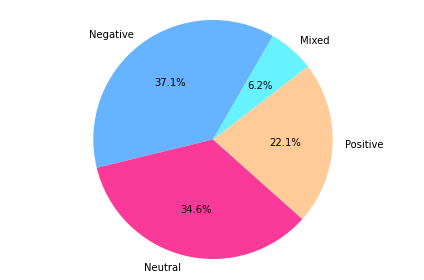

In [15]:
pie(train_data, "Sentiment_label")

**preprocessing the reviews and printing the time spent & Deleting unused fields**

In [16]:
# Cleaning Training Data 
train_data[Tweets_Text_Col_Train] = train_data[Tweets_Text_Col_Train].apply(lambda x:   data_cleaning(x))

# Removing un-needed feilds
train_data.drop(['#Tweet_ID'], axis = 1, inplace = True)
train_data.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'


,Tweet_text,Sentiment_label
0,المباراة القادمة غانا x مصر الجولة الاخيرة من ...,Positive
1,هل هذه هي سياسة خارجيه لدوله تحترم نفسها والاخ...,Negative
2,وزير خارجية فرنسا عن منتدى شباب العالم شعرت با...,Positive


**Spliting Data (Train , Evaluation)**

In [26]:
# First setting the max_len , will be useful later for BERT Model
Extra_Len = 6 # an extra padding in length , found to be useful for increasing F-score
Max_Len = train_data[Tweets_Text_Col_Train].str.split().str.len().max() + Extra_Len
print(Max_Len)

#Spliting the Training data
Test_Size = 0.20 
                     
Rand_Seed = 42 

train_set, evaluation_set = train_test_split( train_data, test_size= Test_Size, random_state= Rand_Seed)

y=pd.get_dummies(train_data.Sentiment_label)

train_set, X_test, y_train, y_test = train_test_split(train_data, y, test_size = 0.20, random_state = 42)

print("Train set: ")
print(train_set[Tweets_Sentiment_Col_Train].value_counts())
print("---------------------------")
print ("Evaluation set: ")
print (evaluation_set[Tweets_Sentiment_Col_Train].value_counts())

142
Train set: 
Negative    6225
Neutral     5824
Positive    3698
Mixed       1049
Name: Sentiment_label, dtype: int64
---------------------------
Evaluation set: 
Negative    1573
Neutral     1441
Positive     933
Mixed        253
Name: Sentiment_label, dtype: int64


**Preparing BERTModel Classes**

In [18]:
Model_Used = "UBC-NLP/MARBERT"
Task_Name = "classification"

class Dataset:
    def __init__(
        self,
        name,
        train,
        test,
        label_list,
    ):
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list
        
class BERTModelDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(BERTModelDataset).__init__()
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map
  
    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = " ".join(text.split())
    
      encoded_review = self.tokenizer.encode_plus(
      text,
      max_length= self.max_len,
      add_special_tokens= True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      truncation='longest_first',
      return_attention_mask=True,
      return_tensors='pt'
    )
      input_ids = encoded_review['input_ids'].to(device)
      attention_mask = encoded_review['attention_mask'].to(device)

      return InputFeatures(input_ids=input_ids.flatten(), attention_mask=attention_mask.flatten(), label=self.label_map[self.target[item]])

**Defining Needed Methods for training and evaluation**

In [19]:
def model_init():
  return AutoModelForSequenceClassification.from_pretrained(Model_Used, return_dict=True, num_labels=len(label_map))

def compute_metrics(p): #p should be of type EvalPrediction
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)
  print(classification_report(p.label_ids,preds))
  #print(confusion_matrix(p.label_ids,preds))

  macro_f1_pos_neg = f1_score(p.label_ids,preds,average='macro',labels=[1,2])
  macro_f1 = f1_score(p.label_ids,preds,average='macro')
  macro_precision = precision_score(p.label_ids,preds,average='macro')
  macro_recall = recall_score(p.label_ids,preds,average='macro')
  acc = accuracy_score(p.label_ids,preds)
  return {
      'macro_f1' : macro_f1,
      'macro_f1_pos_neg' : macro_f1_pos_neg,  
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': acc
  }

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

**Build Train and Evaluation Data Sets**

In [20]:
label_list = list(train_set[Tweets_Sentiment_Col_Train].unique())

print(label_list)
print(train_set[Tweets_Sentiment_Col_Train].value_counts())

data_set = Dataset( "ArSAS", train_set, evaluation_set, label_list )

label_map = { v:index for index, v in enumerate(label_list) }
print(label_map)

train_dataset = BERTModelDataset(train_set[Tweets_Text_Col_Train].to_list(),
                                 train_set[Tweets_Sentiment_Col_Train].to_list(),Model_Used,Max_Len,label_map)

evaluation_dataset = BERTModelDataset(evaluation_set[Tweets_Text_Col_Train].to_list(),
                                      evaluation_set[Tweets_Sentiment_Col_Train].to_list(),Model_Used,Max_Len,label_map)

['Neutral', 'Negative', 'Positive', 'Mixed']
Negative    6225
Neutral     5824
Positive    3698
Mixed       1049
Name: Sentiment_label, dtype: int64
{'Neutral': 0, 'Negative': 1, 'Positive': 2, 'Mixed': 3}


Downloading:   0%|          | 0.00/701 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

**Define Training Arguments**

In [21]:
#define training arguments
training_args = TrainingArguments("./train")
training_args.lr_scheduler_type = 'cosine'
training_args.evaluate_during_training = True
training_args.adam_epsilon =1e-8 
training_args.learning_rate = 1.78255000000000001e-05 # use this with org data  
training_args.fp16 = True
training_args.per_device_train_batch_size = 16  
training_args.per_device_eval_batch_size = 128 
training_args.gradient_accumulation_steps = 2
training_args.num_train_epochs= 2
training_args.warmup_steps = 0 
training_args.evaluation_strategy = EvaluationStrategy.EPOCH
training_args.logging_steps = 200
training_args.save_steps = 100000 
training_args.seed = 42 
training_args.disable_tqdm = False

**Build The Trainer**

In [22]:
training_args.dataloader_pin_memory = False
gc.collect()
torch.cuda.empty_cache()
set_seed(Rand_Seed) 

trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset= evaluation_dataset,
    compute_metrics=compute_metrics
)

print(training_args.seed)

Downloading:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at U

42


**Train**

In [23]:
all_results = []

print(Max_Len)
print(training_args.learning_rate)
print(training_args.adam_epsilon)
print(training_args.warmup_steps)
trainer.train()

results = trainer.evaluate()
all_results.append(results)
print(results)

142
1.78255e-05
1e-08
0


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch,Training Loss,Validation Loss,Macro F1,Macro F1 Pos Neg,Macro Precision,Macro Recall,Accuracy,Runtime,Samples Per Second
1,0.607700,0.569811,0.613973,0.786606,0.694312,0.625396,0.789286,11.586500,362.492000
2,0.400900,0.597260,0.653482,0.791730,0.668300,0.650245,0.788810,11.723100,358.268000


              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1441
           1       0.80      0.87      0.83      1573
           2       0.74      0.74      0.74       933
           3       0.43      0.02      0.04       253

    accuracy                           0.79      4200
   macro avg       0.69      0.63      0.61      4200
weighted avg       0.77      0.79      0.77      4200



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


              precision    recall  f1-score   support

           0       0.81      0.86      0.84      1441
           1       0.83      0.85      0.84      1573
           2       0.74      0.74      0.74       933
           3       0.28      0.15      0.19       253

    accuracy                           0.79      4200
   macro avg       0.67      0.65      0.65      4200
weighted avg       0.77      0.79      0.78      4200



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


              precision    recall  f1-score   support

           0       0.81      0.86      0.84      1441
           1       0.83      0.85      0.84      1573
           2       0.74      0.74      0.74       933
           3       0.28      0.15      0.19       253

    accuracy                           0.79      4200
   macro avg       0.67      0.65      0.65      4200
weighted avg       0.77      0.79      0.78      4200

{'eval_loss': 0.5972602367401123, 'eval_macro_f1': 0.6534821491758084, 'eval_macro_f1_pos_neg': 0.7917304439371178, 'eval_macro_precision': 0.6682995144970398, 'eval_macro_recall': 0.6502452795740927, 'eval_accuracy': 0.7888095238095238, 'eval_runtime': 11.7431, 'eval_samples_per_second': 357.655, 'epoch': 2.0}


**Results**

In [24]:
all_results

[{'epoch': 2.0,
  'eval_accuracy': 0.7888095238095238,
  'eval_loss': 0.5972602367401123,
  'eval_macro_f1': 0.6534821491758084,
  'eval_macro_f1_pos_neg': 0.7917304439371178,
  'eval_macro_precision': 0.6682995144970398,
  'eval_macro_recall': 0.6502452795740927,
  'eval_runtime': 11.7431,
  'eval_samples_per_second': 357.655}]

In [25]:
from statistics import mean
mean([x['eval_macro_f1'] for x in all_results])

0.6534821491758084